# DeepDream

Questo notebook è una versione semplificata dell'esempio ufficiale di Google:<br />
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

Per eseguirlo è sufficiente installare TensorFlow:
https://www.tensorflow.org/install/

Prima di cominciare, potete scaricare il modello di rete neurale pre-allenata qui:
https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip

Alcuni import di base:

In [1]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

Codice per caricare il modello Inception da file:

In [2]:
model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

Dal modello possiamo recuperare l'uscita di ciascun layer conoscendone il nome:

In [3]:
def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

L'algoritmo base di DeepDream non è altro che una ottimizzazione rispetto all'input della rete neurale:

In [4]:
def render_deepdream(t_obj, img0, iter_n=50, step=1.5):
    
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    img = img0.copy()
    for i in range(iter_n):

        g, score = sess.run([t_grad, t_score], {t_input:img})
        
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        
        img += g*step
        
        print(score, end = ' ')
        
    clear_output()
    showarray(visstd(img))

Funzione helper per mostrare un'immagine su schermo:

In [5]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

Quest'altra funzione helper normalizza l'immagine prima di visualizzarla:

In [6]:
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

Per semplificare gli esperimenti, partiamo da un'immagine di puro rumore:

In [10]:
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

Eseguiamo il tutto:

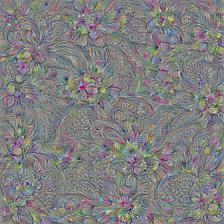

In [8]:
layer = 'mixed4d_3x3_bottleneck_pre_relu'
render_deepdream(T(layer)[:,:,:,139], img_noise)

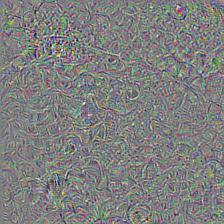

In [11]:
layer = 'mixed5b_5x5_pre_relu'
render_deepdream(T(layer), img_noise)